<a href="https://colab.research.google.com/github/hochthom/OG-AI4Artists-2021/blob/main/Lecture3_Pix2Pix_Example/Pix2Pix_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pix2Pix Example
===============


In [15]:
import os
from tqdm.notebook import tqdm 
import numpy as np
import datetime
import tensorflow as tf
from matplotlib import pyplot as plt
%matplotlib inline

from pix2pix import load_image_train, load_image_test
from pix2pix import Generator, Discriminator, generator_loss, discriminator_loss
from datagen import DataGenerator

Initializing the data
=====================

In [3]:
!ls -l /content/drive/MyDrive/AI4Artists/OG-AI4Artists-2021/data/Lecture3_Pix2Pix/

total 4
drwx------ 2 root root 4096 Apr 30 13:20 APDrawingDB


In [3]:
DATA_DIR = '/content/drive/MyDrive/AI4Artists/OG-AI4Artists-2021/data/Lecture3_Pix2Pix/APDrawingDB'
print(os.path.exists(DATA_DIR))

EPOCHS = 5

True


In [19]:
# CREATE Datasets
# -----------------------------------------------------------------------------
TRAIN_IMAGE_DIR = os.path.join(DATA_DIR, 'train')
imgs = os.listdir(TRAIN_IMAGE_DIR)
train_dataset = DataGenerator(imgs, TRAIN_IMAGE_DIR)

TEST_IMAGE_DIR = os.path.join(DATA_DIR, 'test')
imgs = os.listdir(TEST_IMAGE_DIR)
test_dataset = DataGenerator(imgs, TEST_IMAGE_DIR)

Creating the model
==================

In [7]:
generator = Generator()
generator.summary()

discriminator = Discriminator()
discriminator.summary()

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 256, 256, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 128, 128, 128 131584      sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 64, 64, 256)  525312      sequential_1[0][0]               
______________________________________________________________________________________________

In [8]:
@tf.function
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                            generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                                 discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                            generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                                discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', tf.reduce_mean(gen_total_loss), step=epoch)
        tf.summary.scalar('gen_gan_loss', tf.reduce_mean(gen_gan_loss), step=epoch)
        tf.summary.scalar('gen_l1_loss', tf.reduce_mean(gen_l1_loss), step=epoch)
        tf.summary.scalar('disc_loss', tf.reduce_mean(disc_loss), step=epoch)

Model Training
==============

In [9]:
log_dir = './logs'
if not os.path.exists(log_dir):
  os.mkdir(log_dir)
log_file = os.path.join(log_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
summary_writer = tf.summary.create_file_writer(log_file)

checkpoint_dir = './checkpoints'
if not os.path.exists(checkpoint_dir):
  os.mkdir(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [10]:
for epoch in range(EPOCHS):
    print('\n')
    print("Epoch: ", epoch + 1)

    # Train
    for input_image, target in tqdm(train_dataset):
        train_step(input_image, target, epoch)

    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 20 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)

checkpoint.save(file_prefix=checkpoint_prefix)



Epoch:  1





Epoch:  2





Epoch:  3





Epoch:  4





Epoch:  5


'./checkpoints/ckpt-1'

In [30]:
!ls -l ./checkpoints

total 1340476
-rw-r--r-- 1 root root        69 May  2 15:42 checkpoint
-rw-r--r-- 1 root root 686294125 May  2 15:20 ckpt-1.data-00000-of-00001
-rw-r--r-- 1 root root     16442 May  2 15:20 ckpt-1.index
-rw-r--r-- 1 root root 686294125 May  2 15:42 ckpt-2.data-00000-of-00001
-rw-r--r-- 1 root root     16442 May  2 15:42 ckpt-2.index


Creating images with the trained model
======================================

In [25]:
def show_images(test_img, target, gen_img):
    display_list = [test_img[0], target[0], gen_img[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    plt.figure(figsize=(15,6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        #plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


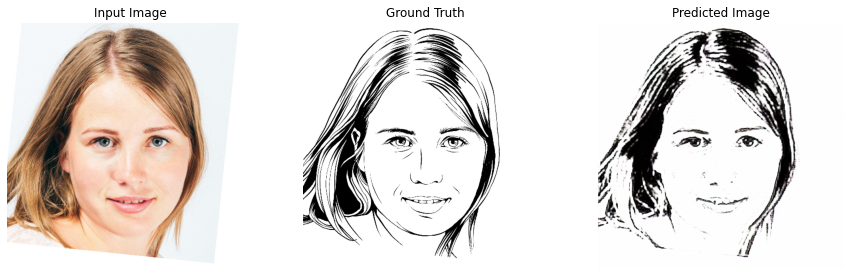

In [26]:
# create samples
# -----------------------------------------------------------------------------
inp, tgt = test_dataset.sample()
#inp, tgt = next(iter(test_dataset))
gen_img = generator(inp, training=False)

show_images(inp, tgt, gen_img)